In [32]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("Courses.csv")

In [33]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("Courses.csv")

# 1. Remove specified columns
columns_to_remove = ['nplay_video', 'incomplete_flag', 'roles']
df_cleaned = df.drop(columns=columns_to_remove)

# 2. Handle missing values
# For categorical variables (LoE_DI) - impute with mode
df_cleaned['LoE_DI'] = df_cleaned['LoE_DI'].fillna(df_cleaned['LoE_DI'].mode()[0])

# For gender in random way
missing_indices = df_cleaned[df_cleaned['gender'].isnull()].index
df_cleaned.loc[missing_indices, 'gender'] = np.random.choice(df_cleaned['gender'].dropna(), len(missing_indices))

# For YoB - impute with median
df_cleaned['YoB'] = df_cleaned['YoB'].fillna(df_cleaned['YoB'].median())

# 3. Drop rows with missing grades
df_cleaned = df_cleaned.dropna(subset=['grade'])

# 5. Define function for nchapters imputation
def impute_nchapters_simple(df):
    # Create copy of original nchapters
    df['nchapters_imputed'] = df['nchapters'].copy()
    
    # Imputation logic based on certification and activity days
    mask = df['nchapters'].isna()
    
    conditions = [
        # Condition 1: Certified students
        (mask) & (df['certified'] == 1),
        # Condition 2: Not certified but active (ndays_act > 3)
        (mask) & (df['certified'] == 0) & (df['ndays_act'] > 3),
        # Condition 3: Not certified and some activity (ndays_act <= 3)
        (mask) & (df['certified'] == 0) & (df['ndays_act'] <= 3),
        # Condition 4: No activity recorded (ndays_act is NaN) but viewed course
        (mask) & (df['ndays_act'].isna()) & (df['viewed'] == 1),
        # Condition 5: No activity and never viewed (complete non-engagement)
        (mask) & (df['ndays_act'].isna()) & (df['viewed'] == 0)
    ]
    
    values = [
        16,  # Average for certified students
        3,   # Average for non-certified active students
        1,   # Minimal engagement
        1,   # Viewed but no sustained activity
        0    # Never engaged with content
    ]
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Apply imputation
    df['nchapters_imputed'] = np.select(conditions, values, df['nchapters_imputed'])
    
    return df['nchapters_imputed']

# Apply nchapters imputation
df_cleaned['nchapters_imputed'] = impute_nchapters_simple(df_cleaned)

# 6. nevents missing data
def impute_nevents(row):
    if pd.isna(row['nevents']):  # Only impute if the value is missing
        if row['nchapters'] == 0:
            return 0
        elif row['nchapters'] == 1:
            return np.random.choice([0, 1], p=[0.7, 0.3])
        elif 2 <= row['nchapters'] <= 5:
            return np.random.choice([0, 1, 2], p=[0.5, 0.3, 0.2])
        elif 6 <= row['nchapters'] <= 12:
            return np.random.choice([1, 2, 3], p=[0.4, 0.4, 0.2])
        else:
            return np.random.choice([2, 3, 4], p=[0.3, 0.4, 0.3])
    else:
        return row['nevents']  # Return original value if not missing

# Set random seed for reproducibility
np.random.seed(42)

# Create new column with imputed values
df_cleaned['nevents_imputed'] = df_cleaned.apply(impute_nevents, axis=1)

# 7. Save the cleaned dataset with all changes
df_cleaned.to_csv('cleaned_dataset.csv', index=False)


In [3]:
import pandas as pd
import numpy as np

# Load the cleaned dataset
df_cleaned = pd.read_csv('cleaned_dataset.csv')

# Convert to numeric and handle NaN values
df_cleaned['viewed'] = pd.to_numeric(df_cleaned['viewed'], errors='coerce').fillna(0).astype(int)
df_cleaned['explored'] = pd.to_numeric(df_cleaned['explored'], errors='coerce').fillna(0).astype(int)
df_cleaned['certified'] = pd.to_numeric(df_cleaned['certified'], errors='coerce').fillna(0).astype(int)
df_cleaned['grade'] = pd.to_numeric(df_cleaned['grade'], errors='coerce').fillna(0)
df_cleaned['nevents_imputed'] = pd.to_numeric(df_cleaned['nevents_imputed'], errors='coerce').fillna(0)
df_cleaned['nchapters_imputed'] = pd.to_numeric(df_cleaned['nchapters_imputed'], errors='coerce').fillna(0)

# Convert ID columns to strings
df_cleaned['userid_DI'] = df_cleaned['userid_DI'].astype(str)
df_cleaned['course_id'] = df_cleaned['course_id'].astype(str)

# Save the updated dataset
df_cleaned.to_csv('cleaned_dataset.csv', index=False)

# Let's analyze the dataset
print("\n=== Dataset Overview ===")
print(f"Number of rows: {len(df_cleaned)}")
print(f"Number of columns: {len(df_cleaned.columns)}")
print("\n=== Data Types ===")
print(df_cleaned.dtypes)

print("\n=== Basic Statistics ===")
print(df_cleaned.describe())

print("\n=== Missing Values ===")
print(df_cleaned.isnull().sum())

print("\n=== Sample of First Few Rows ===")
print(df_cleaned.head())

# Additional analysis for binary columns
binary_cols = ['viewed', 'explored', 'certified']
print("\n=== Binary Columns Distribution ===")
for col in binary_cols:
    print(f"\n{col} value counts:")
    print(df_cleaned[col].value_counts(normalize=True).round(3) * 100, "%")



=== Dataset Overview ===
Number of rows: 592766
Number of columns: 19

=== Data Types ===
course_id             object
userid_DI             object
registered             int64
viewed                 int32
explored               int32
certified              int32
final_cc_cname_DI     object
LoE_DI                object
YoB                  float64
gender                object
grade                float64
start_time_DI         object
last_event_DI         object
nevents              float64
ndays_act            float64
nchapters            float64
nforum_posts           int64
nchapters_imputed    float64
nevents_imputed      float64
dtype: object

=== Basic Statistics ===
       registered         viewed       explored      certified            YoB  \
count    592766.0  592766.000000  592766.000000  592766.000000  592766.000000   
mean          1.0       0.631195       0.065592       0.029838    1985.637746   
std           0.0       0.482481       0.247569       0.170141       8.2543

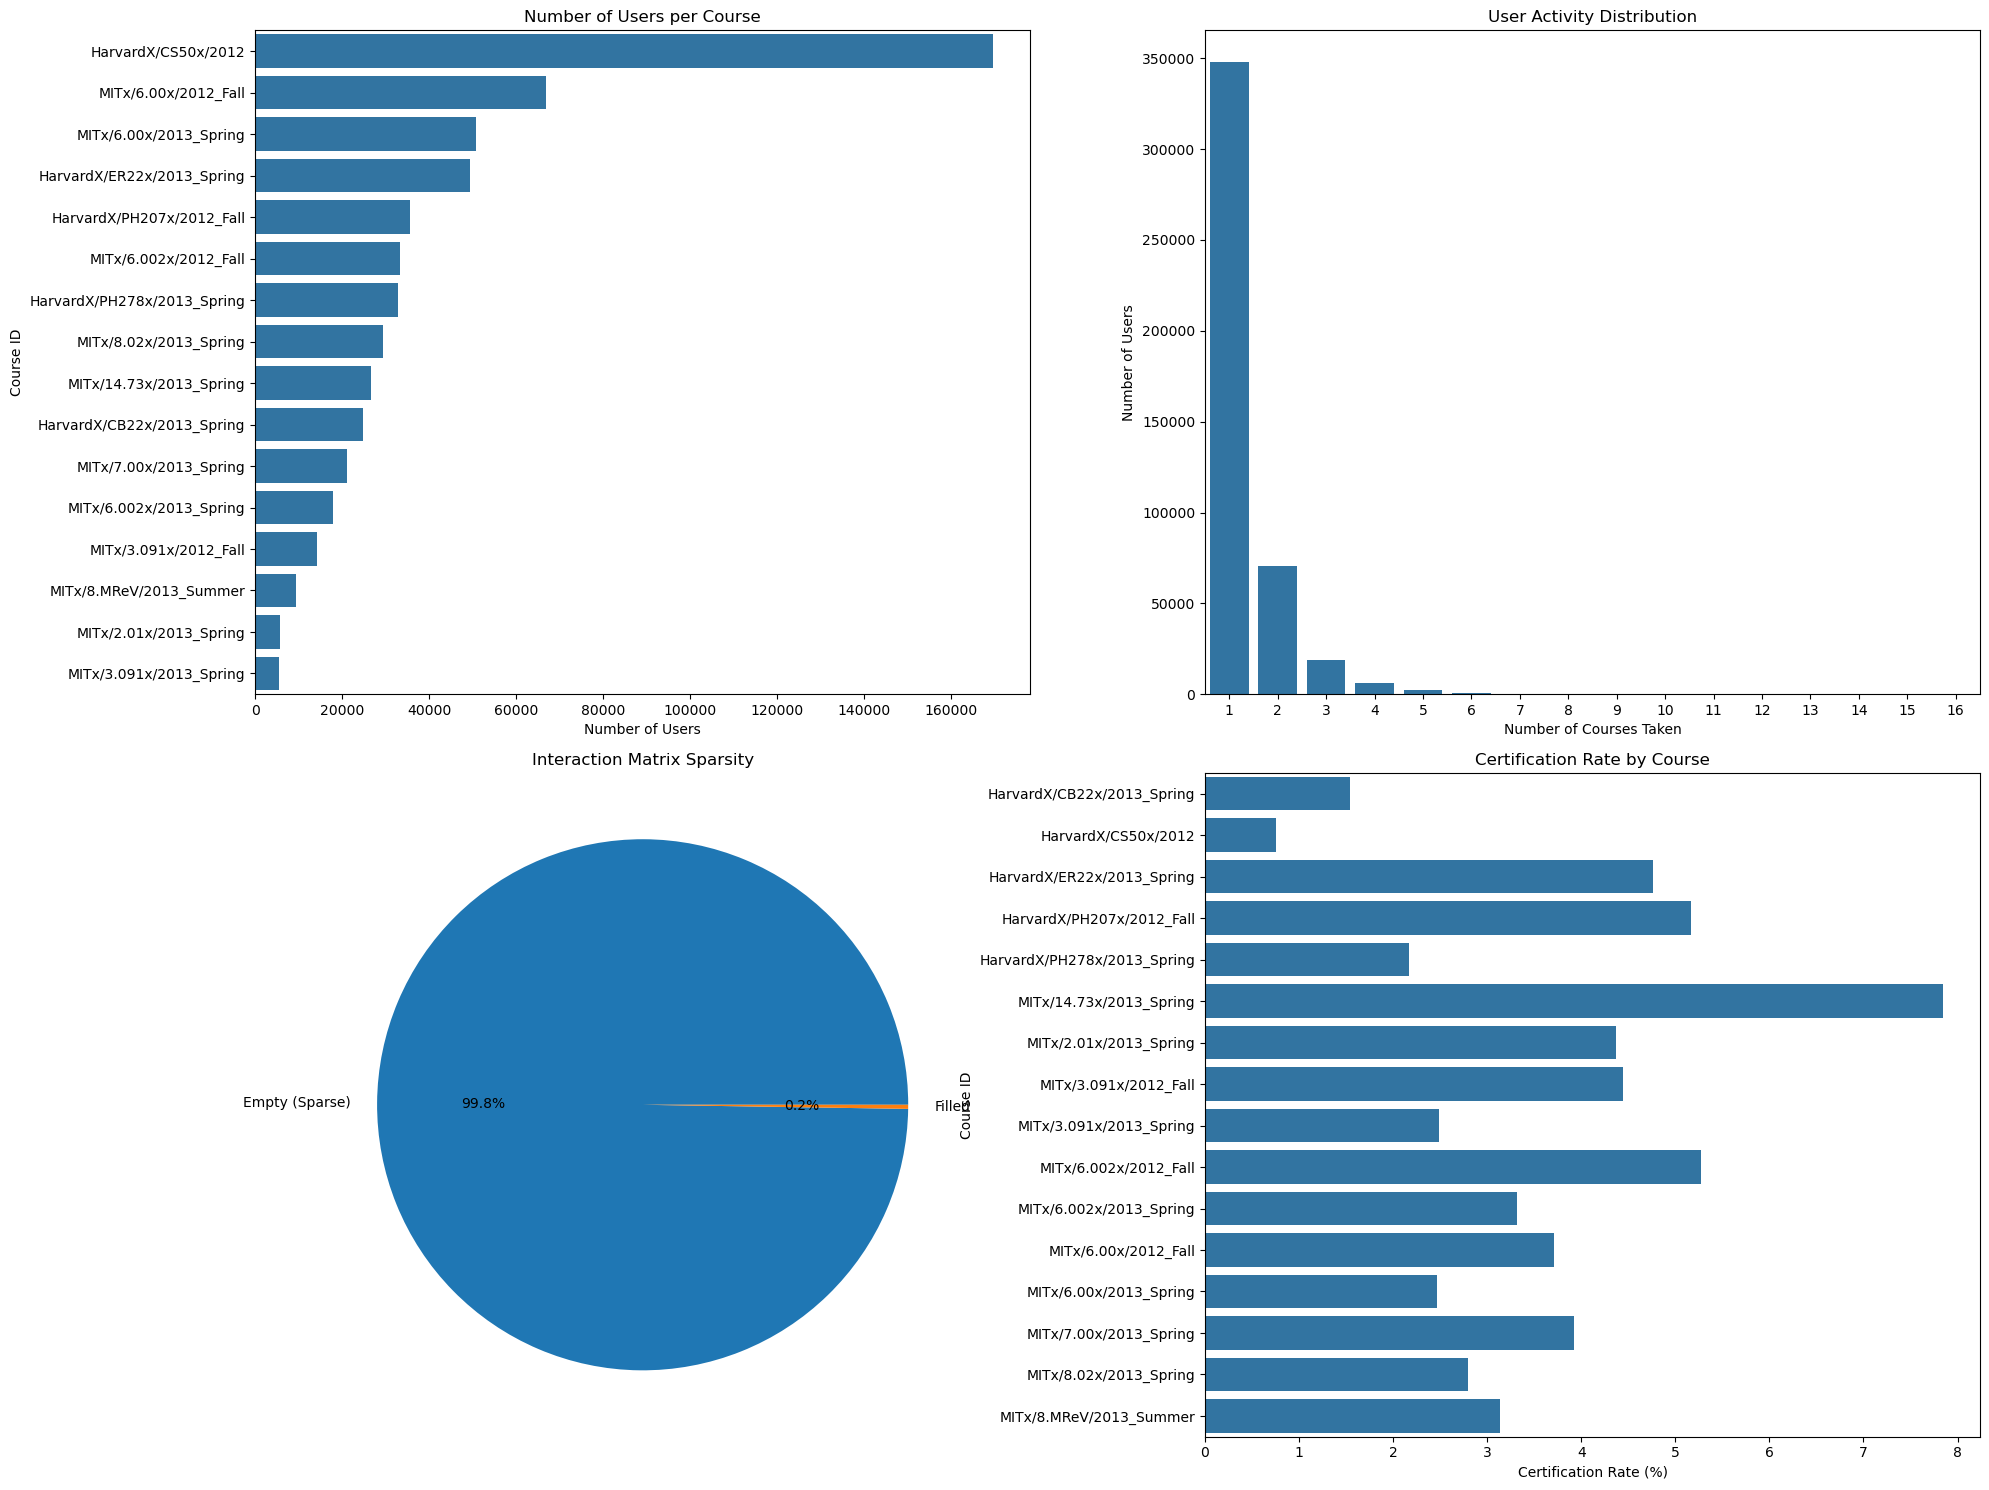

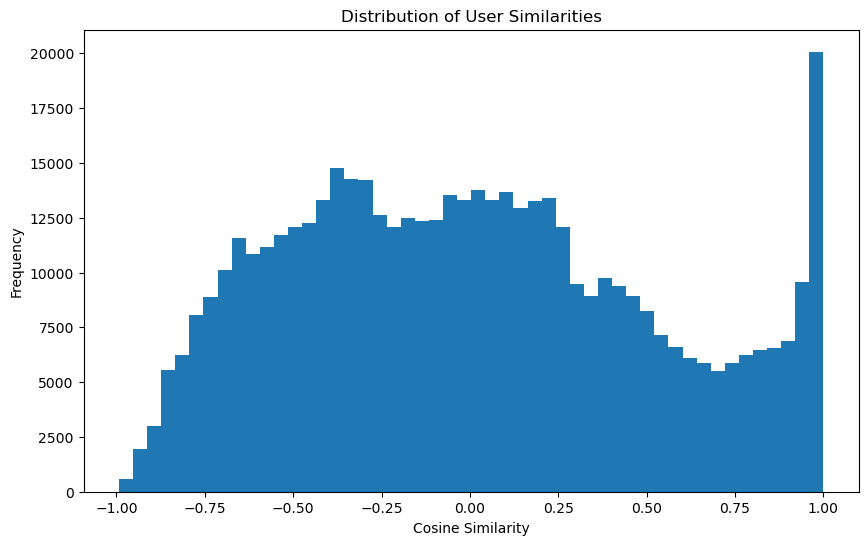

In [10]:
#plots shows why this result happens
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load the data
df = pd.read_csv('cleaned_dataset.csv')

# Create figure with subplots
#plt.style.use('seaborn')
fig = plt.figure(figsize=(20, 15))

# 1. Course Distribution
ax1 = plt.subplot(2, 2, 1)
course_counts = df['course_id'].value_counts()
sns.barplot(x=course_counts.values, y=course_counts.index, ax=ax1)
ax1.set_title('Number of Users per Course')
ax1.set_xlabel('Number of Users')
ax1.set_ylabel('Course ID')

# 2. User Activity Distribution
ax2 = plt.subplot(2, 2, 2)
user_activity = df.groupby('userid_DI').size()
user_activity_dist = pd.Series(Counter(user_activity))
sns.barplot(x=user_activity_dist.index, y=user_activity_dist.values, ax=ax2)
ax2.set_title('User Activity Distribution')
ax2.set_xlabel('Number of Courses Taken')
ax2.set_ylabel('Number of Users')

# 3. Sparsity Visualization
ax3 = plt.subplot(2, 2, 3)
interactions = pd.pivot_table(
    data=df,
    index='userid_DI',
    columns='course_id',
    values='certified',
    fill_value=0
)
sparsity = (interactions == 0).sum().sum() / (interactions.shape[0] * interactions.shape[1]) * 100
dense = (interactions != 0).sum().sum() / (interactions.shape[0] * interactions.shape[1]) * 100

plt.pie([sparsity, dense], labels=['Empty (Sparse)', 'Filled'], autopct='%1.1f%%')
ax3.set_title('Interaction Matrix Sparsity')

# 4. Certification Rate by Course
ax4 = plt.subplot(2, 2, 4)
cert_rate = df.groupby('course_id')['certified'].mean() * 100
sns.barplot(x=cert_rate.values, y=cert_rate.index, ax=ax4)
ax4.set_title('Certification Rate by Course')
ax4.set_xlabel('Certification Rate (%)')
ax4.set_ylabel('Course ID')

plt.tight_layout()
plt.show()

# Additional plot for user similarity distribution
plt.figure(figsize=(10, 6))
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Sample a subset of users for similarity calculation (to avoid memory issues)
sample_size = 1000
user_profiles = df.groupby('userid_DI').agg({
    'final_cc_cname_DI': 'first',
    'LoE_DI': 'first',
    'YoB': 'first',
    'gender': 'first'
}).reset_index().sample(sample_size, random_state=42)

# Prepare features
categorical_cols = ['final_cc_cname_DI', 'LoE_DI', 'gender']
for col in categorical_cols:
    user_profiles[col] = pd.Categorical(user_profiles[col]).codes

user_profiles['YoB'] = pd.to_numeric(user_profiles['YoB'], errors='coerce')
user_profiles['YoB'].fillna(user_profiles['YoB'].mean(), inplace=True)

# Calculate similarities
features = user_profiles[['YoB'] + categorical_cols]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
similarities = cosine_similarity(features_scaled)

# Plot similarity distribution
similarities_flat = similarities[np.triu_indices(similarities.shape[0], k=1)]
plt.hist(similarities_flat, bins=50)
plt.title('Distribution of User Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

class MemoryEfficientRecommender:
    def __init__(self, batch_size=1000, n_neighbors=5):
        self.batch_size = batch_size
        self.n_neighbors = n_neighbors
        self.knn = NearestNeighbors(n_neighbors=n_neighbors + 1, metric='cosine', algorithm='brute')
        
    def fit(self, X, user_profiles, interactions):
        self.X = X
        self.user_profiles = user_profiles
        self.interactions = interactions
        self.user_id_map = dict(zip(range(len(user_profiles)), user_profiles['userid_DI']))
        # Create course ID mapping
        self.course_id_map = {course: idx for idx, course in enumerate(interactions.columns)}
        self.reverse_course_map = {idx: course for course, idx in self.course_id_map.items()}
        self.knn.fit(X)
        return self
    
    def recommend_batch(self, start_idx, end_idx, n_recommendations=5):
        batch_X = self.X[start_idx:end_idx]
        
        # Find k nearest neighbors
        distances, indices = self.knn.kneighbors(batch_X)
        
        recommendations = []
        for i, user_neighbors in enumerate(indices):
            # Remove self from neighbors
            user_neighbors = user_neighbors[1:]
            
            # Get similar users' interactions
            similar_user_ids = [self.user_id_map[idx] for idx in user_neighbors]
            valid_user_ids = [uid for uid in similar_user_ids if uid in self.interactions.index]
            
            if not valid_user_ids:
                recommendations.append(pd.Series())
                continue
                
            similar_interactions = self.interactions.loc[valid_user_ids]
            
            # Calculate course scores
            course_scores = similar_interactions.mean()
            
            # Filter out courses already taken
            current_user_id = self.user_id_map[start_idx + i]
            if current_user_id in self.interactions.index:
                user_interactions = self.interactions.loc[current_user_id]
                already_taken = user_interactions[user_interactions > 0].index
                course_scores[already_taken] = -1
            
            # Get top recommendations
            top_courses = course_scores.nlargest(n_recommendations)
            recommendations.append(top_courses)
            
        return recommendations

def prepare_data(df):
    # Create user profiles
    user_profiles = df.groupby('userid_DI').agg({
        'final_cc_cname_DI': 'first',
        'LoE_DI': 'first',
        'YoB': 'first',
        'gender': 'first'
    }).reset_index()
    
    # Create interaction matrix
    interactions = pd.pivot_table(
        data=df,
        index='userid_DI',
        columns='course_id',
        values='certified',
        fill_value=0
    )
    
    return user_profiles, interactions

def engineer_features(user_profiles):
    le_dict = {}
    categorical_cols = ['final_cc_cname_DI', 'LoE_DI', 'gender']
    
    for col in categorical_cols:
        le = LabelEncoder()
        user_profiles[f'{col}_encoded'] = le.fit_transform(user_profiles[col].astype(str))
        le_dict[col] = le
    
    scaler = StandardScaler()
    user_profiles['YoB'] = pd.to_numeric(user_profiles['YoB'], errors='coerce')
    user_profiles['YoB'].fillna(user_profiles['YoB'].mean(), inplace=True)
    user_profiles['YoB_scaled'] = scaler.fit_transform(user_profiles[['YoB']])
    
    feature_cols = [col for col in user_profiles.columns if '_encoded' in col or '_scaled' in col]
    X = user_profiles[feature_cols].values
    
    return X, user_profiles, le_dict

def evaluate_batch(recommender, test_interactions, user_profiles, X, batch_size=1000):
    n_users = len(user_profiles)
    all_predictions = []
    all_actuals = []
    
    for start_idx in range(0, n_users, batch_size):
        end_idx = min(start_idx + batch_size, n_users)
        
        batch_recommendations = recommender.recommend_batch(start_idx, end_idx)
        
        for i, recs in enumerate(batch_recommendations):
            if recs.empty:
                continue
                
            user_idx = start_idx + i
            
            # Create binary vector using course mapping
            pred_vector = np.zeros(len(test_interactions.columns))
            for course in recs.index:
                if course in recommender.course_id_map:
                    idx = recommender.course_id_map[course]
                    pred_vector[idx] = 1
            
            # Get actual interactions
            user_id = recommender.user_id_map[user_idx]
            if user_id in test_interactions.index:
                actual = test_interactions.loc[user_id].values
                
                all_predictions.append(pred_vector)
                all_actuals.append(actual)
    
    if not all_predictions:
        return {
            'precision': 0,
            'recall': 0,
            'f1_score': 0
        }
    
    predictions = np.vstack(all_predictions)
    actuals = np.vstack(all_actuals)
    
    precision = precision_score(actuals, predictions, average='macro', zero_division=0)
    recall = recall_score(actuals, predictions, average='macro', zero_division=0)
    f1 = f1_score(actuals, predictions, average='macro', zero_division=0)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def main():
    print("Loading data...")
    df = pd.read_csv('cleaned_dataset.csv')
    
    print("\nDataset Info:")
    print(f"Number of rows: {len(df)}")
    print(f"Number of unique users: {df['userid_DI'].nunique()}")
    print(f"Number of unique courses: {df['course_id'].nunique()}")
    
    print("\nPreparing data...")
    user_profiles, interactions = prepare_data(df)
    print(f"User profiles shape: {user_profiles.shape}")
    print(f"Interactions matrix shape: {interactions.shape}")
    
    print("\nEngineering features...")
    X, user_profiles, le_dict = engineer_features(user_profiles)
    print(f"Feature matrix shape: {X.shape}")
    
    print("\nSplitting data...")
    train_interactions, test_interactions = train_test_split(
        interactions, test_size=0.2, random_state=42
    )
    
    print("\nTraining recommender...")
    recommender = MemoryEfficientRecommender(batch_size=1000, n_neighbors=5)
    recommender.fit(X, user_profiles, train_interactions)
    
    print("\nEvaluating...")
    metrics = evaluate_batch(recommender, test_interactions, user_profiles, X)
    
    print("\nEvaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nExample recommendations for first 5 users:")
    first_batch_recs = recommender.recommend_batch(0, 5)
    for i, recs in enumerate(first_batch_recs):
        if not recs.empty:
            print(f"\nUser {user_profiles.iloc[i]['userid_DI']}:")
            for course, score in recs.items():
                print(f"Course: {course}, Score: {score:.4f}")

if __name__ == "__main__":
    main()


Loading data...

Dataset Info:
Number of rows: 592766
Number of unique users: 447584
Number of unique courses: 16

Preparing data...
User profiles shape: (447584, 5)
Interactions matrix shape: (447584, 16)

Engineering features...
Feature matrix shape: (447584, 4)

Splitting data...

Training recommender...

Evaluating...

Evaluation Metrics:
precision: 0.0072
recall: 0.3299
f1_score: 0.0107

Example recommendations for first 5 users:

User MHxPC130000002:
Course: HarvardX/CB22x/2013_Spring, Score: 0.0000
Course: HarvardX/CS50x/2012, Score: 0.0000
Course: HarvardX/ER22x/2013_Spring, Score: 0.0000
Course: HarvardX/PH207x/2012_Fall, Score: 0.0000
Course: HarvardX/PH278x/2013_Spring, Score: 0.0000

User MHxPC130000003:
Course: MITx/6.002x/2013_Spring, Score: 0.3333
Course: HarvardX/CB22x/2013_Spring, Score: 0.0000
Course: HarvardX/CS50x/2012, Score: 0.0000
Course: HarvardX/ER22x/2013_Spring, Score: 0.0000
Course: HarvardX/PH207x/2012_Fall, Score: 0.0000

User MHxPC130000004:
Course: MITx/